# Make plots of layer orientation

Requires master_orientation.py has already been run

## Import packages

In [562]:
# general
import numpy as np
import pandas as pd
import math
from scipy import stats

# plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# math
from statsmodels.stats.weightstats import DescrStatsW

## Set Filepaths

In [563]:
path_to_angles = '../../data/angles/'
path_to_figures = '../../../figures/cul_de_sac-slopes/'

## Load Angle Data

Requires that master_orientation.py has already been run

In [564]:
alhic2401 = pd.read_pickle(path_to_angles+'alhic2401_angles.df')

## Adjust Aparent Dip for geometry

All aparent dip is calculated in the same reference frame. However, we need to flip one of the two faces for both cores to achieve our definition of a positive dip as sloping down from the center of the core. This means flipping 't' on ALHIC2201 and 'l' on ALHIC2302

In [565]:
# multiply all angles in 'AC-l-angles' by -1 in alhic2401 (assuming similar geometry to ALHIC2302)
for index,row in alhic2401.iterrows():
    alhic2401.at[index,'AC-w2-angles'] = list(map(lambda x: x * -1, row['AC-w2-angles']))

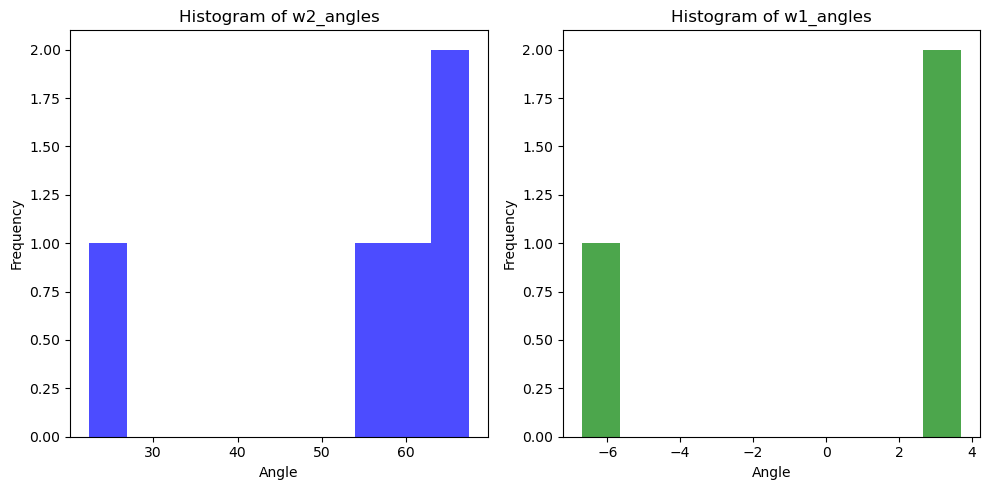

In [566]:
# Choose a section to examine
section_to_examine = alhic2401['section'].iloc[0]  # using the first section
row = alhic2401[alhic2401['section'] == section_to_examine]

l_angles = row['AC-w2-angles'].dropna().to_list()
t_angles = row['AC-w1-angles'].dropna().to_list()

# make a histogram of l_angles and t_angles
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot histogram for l_angles
ax[0].hist(l_angles[0], bins=10, color='blue', alpha=0.7)
ax[0].set_title('Histogram of w2_angles')
ax[0].set_xlabel('Angle')
ax[0].set_ylabel('Frequency')

# plot histogram for t_angles
ax[1].hist(t_angles[0], bins=10, color='green', alpha=0.7)
ax[1].set_title('Histogram of w1_angles')
ax[1].set_xlabel('Angle')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [567]:

# for d1 in row['AC-w1-angles'].to_list()[0]:
#     for d2 in row['AC-w2-angles'].to_list()[0]:

#         print('d1:', d1, 'd2:', d2)

#         alpha = np.arctan(np.tan(np.deg2rad(d2))/np.tan(np.deg2rad(d1))) 

#         #d = np.arctan(np.tan(np.deg2rad(np.deg2rad(d1)))/np.cos(alpha))
#         d = np.arctan(np.tan(np.deg2rad(d1))/np.cos(alpha))

#         print('    alpha:', np.rad2deg(alpha))
#         print('    True Dip:', np.rad2deg(d))

## Calculate True Angle Orientations

In [568]:
# define function to calculate true dip, dip direction, and score

def calc_dip(df,face):

    dip = []
    dip_direction = []
    dip_score = []
    for index,row in df.iterrows():

        # pull out values from the side (first check there are three)
        if row['AC-'+face+'-angles'] != None and len(row['AC-'+face+'-angles']) > 2:
            add_nan = False
            side_angle = np.array(row['AC-'+face+'-angles']) * np.pi/180
            side_score = np.array(row['AC-'+face+'-scores'])
            side_length = np.array(row['AC-'+face+'-length'])
            side_y_offset = np.array(row['AC-'+face+'-y_offset'])
        else:
            add_nan = True

        # pull out values from the top
        if row['AC-w1-angles'] != None and len(row['AC-w1-angles']) > 2:
            top_angle = np.array(row['AC-w1-angles']) * np.pi/180
            top_score = np.array(row['AC-w1-scores'])
            top_length = np.array(row['AC-w1-length'])
            top_y_offset = np.array(row['AC-w1-y_offset'])
        else:
            add_nan = True
        

        # set true angle to nan if we don't have enough data
        if add_nan:
            dip_score_ind = [np.nan]
            dip_dir_ind = [np.nan]
            dip_ind = [np.nan]
        
        # else, calculate dip and save to list
        else:

            # assign delta 1 and delta 2
            if face == 'w2':
                d1 = top_angle
                d2 = side_angle
                
                d1_score = top_score**2 *  top_y_offset  * top_length
                d2_score = side_score**2 * side_y_offset * side_length

            else:
                print('Error: face must be w2')
                break

            # make empty lists
            dip_score_ind = []
            dip_dir_ind = []
            dip_ind = []

            for i in range(len(d2)):
                for j in range(len(d1)):

                    # calculate dip score
                    ds = d1_score[j] * d2_score[i]
                    dip_score_ind.append(ds)

                    # calculate dip direction
                    dd = np.arctan(np.tan(d2[i])/np.tan(d1[j])) 
                    

                    # calculate true dip
                    d = np.arctan(np.tan(d1[j])/np.cos(dd))
                    
                    # now deal with cases where the dip is negative
                    if d<0:
                        d = d*-1
                        dd = dd + np.pi

                    # store values
                    dip_dir_ind.append(dd* 180 / np.pi)
                    dip_ind.append(d* 180 / np.pi)


        # append to lists
        dip.append(dip_ind)
        dip_direction.append(dip_dir_ind)
        dip_score.append(dip_score_ind)

    df['AC-dip'] = dip
    df['AC-dip-direction'] = dip_direction
    df['AC-dip-score'] = dip_score

    return df

In [569]:
alhic2401 = calc_dip(alhic2401,'w2')  # assuming ALHIC2401 has similar geometry to ALHIC2302

## Define function to get weighted percentile

In [570]:
def weighted_percentile(values, weights, percentiles):
    
    # Convert percentiles to fractions
    percentiles = [p / 100 for p in percentiles]

    # Convert values and weights to numpy arrays
    values = np.array(values)
    weights = np.array(weights)
    percentiles = np.array(percentiles)

    # Check for NaN values and remove them
    nan_mask = np.isnan(values) | np.isnan(weights)
    if np.any(nan_mask):
        print("NaN values found and will be removed.")
    values = values[~nan_mask]
    weights = weights[~nan_mask]
    
    # Sort values and weights by values
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    sorted_weights = weights[sorted_indices]
    
    # Compute the cumulative sum of weights
    cumulative_weights = np.cumsum(sorted_weights)
    
    # Normalize the cumulative weights to get the cumulative distribution
    cumulative_distribution = cumulative_weights / cumulative_weights[-1]
    
    # Interpolate to find the weighted percentiles
    weighted_percentiles = np.interp(percentiles, cumulative_distribution, sorted_values)
    
    return weighted_percentiles

## Calulate Percentiles

In [571]:
# define function to calculate percentiles from dataframe with true dip angles
def calc_percentiles(df,percentiles):

    # initialize list to store dip statistics
    dip_stats = []
    # define if we are looking at AC or DC (AC is default)
    ACorDC = 'AC'

    # loop through each row in the dataframe
    for index,row in df.iterrows():

        # pull out approriate data
        dip = np.array(row[ACorDC+'-dip'])
        scores = np.array(row[ACorDC+'-dip-score'])

        # check there isn't one value, indicating nan
        if len(dip)>1:
        
            # plot dip
            a = weighted_percentile(dip, scores, percentiles)
            # weighted_percentile(dip, percentiles, weights=scores, interpolation='step')
            dip_stats.append(a)

            # check
            for i in range(len(a)-1):
                if a[i]>a[i+1]:
                    print('Error: Percentiles are not in order in section '+row['section'])
        else:
            dip_stats.append([np.nan]*len(percentiles))

    df['dip_percentiles'] = dip_stats
    return df

In [572]:
#set percentiles
percentiles = [10,25,50,75,90]

# calculate true dip percentiles for alhic2401
alhic2401 = calc_percentiles(alhic2401,percentiles)

## Rotate dip direction to match geometry

In [573]:
# first up, we have to rotate the dip direction by 180 for all sections where the median dip is negative.

# define function to rotate dip direction by 180 if median dip is negative
def rotate_dip_direction(df):

    # loop through each row in the dataframe
    for index,row in df.iterrows():

        # pull out approriate data
        dip = np.array(row['dip_percentiles'][2])
        #dip_dir = np.array(row['AC-dip-direction'])

        # check if the median dip is negative
        #if dip < 0:

            # save to dataframe
            #df.at[index,'AC-dip-direction'] = np.array(row['AC-dip-direction']) + 180

            #print("Flipping dip direction for section "+row['section']+" because median dip is negative.")
    
        # ensure all angles in df.at[index,'AC-dip-direction'] are between 0 and 360 (check for both >360 and <0). df.at[index,'AC-dip-direction'] is a list.
        df.at[index,'AC-dip-direction'] = [angle - 360 if angle > 360 else angle for angle in df.at[index,'AC-dip-direction']]
        df.at[index,'AC-dip-direction'] = [angle + 360 if angle < 0 else angle for angle in df.at[index,'AC-dip-direction']]

    return df

alhic2401 = rotate_dip_direction(alhic2401)


In [574]:
# Now we have to set dip direction to be angles from the orientation line.
# Assuming ALHIC2401 has similar geometry to ALHIC2302, we'll subtract 90 degrees from dip direction.
# We accomplish this by adding 270 and taking the modulo 360.

#subtract 90 degrees from dip direction in alhic2401
for index,row in alhic2401.iterrows():
 alhic2401.at[index,'AC-dip-direction'] = list(map(lambda x: (x + 270)%360, row['AC-dip-direction']))


## Report Results

In [575]:
# Report the total number of sections in alhic2401, and the number where the AC-dip is not nan
print('Total number of sections in alhic2401: '+str(len(alhic2401)))
print('Number of sections with AC-dip in alhic2401: '+str(len(alhic2401[~alhic2401['AC-dip'].apply(lambda x: np.isnan(x).all())])))

# report the number of sections where the interquartile range is <20 degrees:
print('Number of sections in alhic2401 where the interquartile range is <20 degrees: '+str(len(alhic2401[alhic2401['dip_percentiles'].apply(lambda x: x[3]-x[1]<20)])))

# report the median and standard deviation of the dip (excluding sections where the interquartile range is >20 degrees)
median_dip_2401 = alhic2401[alhic2401['dip_percentiles'].apply(lambda x: x[3] - x[1] < 20)]['dip_percentiles'].apply(lambda x: abs(x[2])).mean()
std_dip_2401 = alhic2401[alhic2401['dip_percentiles'].apply(lambda x: abs(x[3] - x[1]) < 20)]['dip_percentiles'].apply(lambda x: abs(x[2])).std()

print('Median dip for alhic2401 (excluding sections with IQR > 20 degrees):', median_dip_2401)
print('Standard deviation of dip for alhic2401 (excluding sections with IQR > 20 degrees):', std_dip_2401)

# calculate the percentage of sections which meet the IQR threshold
total_sections = len(alhic2401)
total_good_sections = len(alhic2401[alhic2401['dip_percentiles'].apply(lambda x: x[3] - x[1] < 20)])
print('Percentage of sections which meet the IQR threshold:', total_good_sections / total_sections * 100)

Total number of sections in alhic2401: 39
Number of sections with AC-dip in alhic2401: 31
Number of sections in alhic2401 where the interquartile range is <20 degrees: 25
Median dip for alhic2401 (excluding sections with IQR > 20 degrees): 38.365240246986986
Standard deviation of dip for alhic2401 (excluding sections with IQR > 20 degrees): 15.283482789252647
Percentage of sections which meet the IQR threshold: 64.1025641025641


## Make a plot of depth vs dip

In [576]:
# define plotting function (adds interquartile range and median to plot)
def plotstats(d,q,axs,mindip,maxdip):
    
    h = 0.8
    linewidth=1
        
    #box
    axs.add_patch(Rectangle((q[1],d-h/2),(q[3]-q[1]),
                            h,
                            facecolor='k',
                            edgecolor='k',
                            linewidth=1,
                            alpha=0.5))

    # median (change color based on IQR)
    if abs(q[3]-q[1]) > 20:
        axs.plot([q[2],q[2]],[d-h/2,d+h/2],'r',linewidth=3)
    else:
        axs.plot([q[2],q[2]],[d-h/2,d+h/2],'b',linewidth=3)
    
    # centerile
    axs.plot([mindip,maxdip],[d,d],'k',linewidth=linewidth)    


In [ ]:
# set threshold to ignore
threshold = 20

# define core breaks for ALHIC2401
# Replace these values with the actual core break depths for ALHIC2401
alhic2401_breaks = [13.44,15.81,17.55]  # Example values, replace with actual values


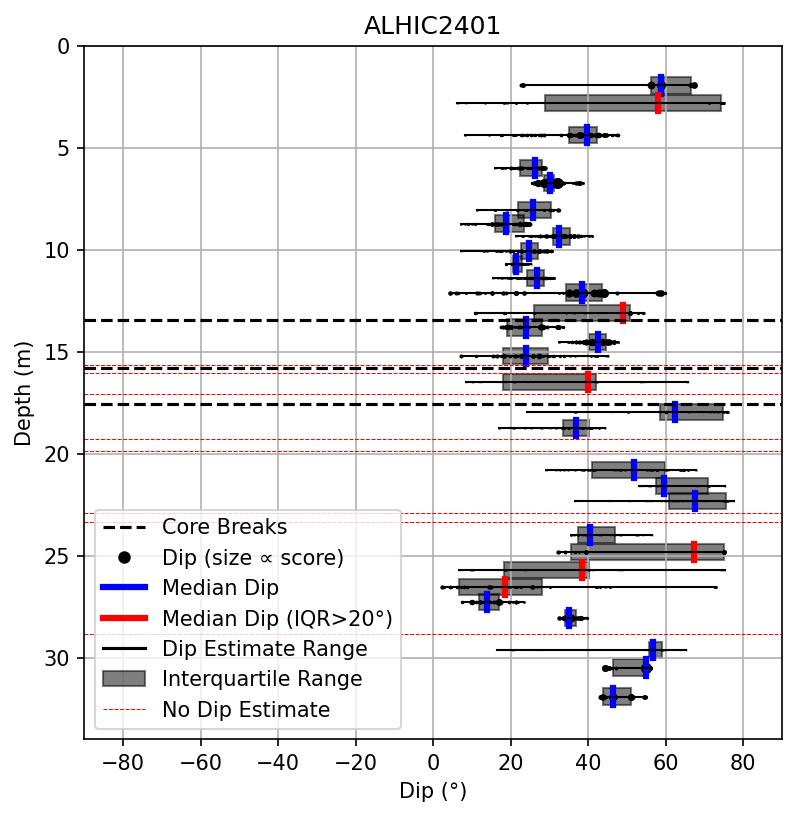

In [578]:
# make figure
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=150)

# axis labels
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Dip (°)')
ax.set_xlim(-90,90)
ax.grid(True)
ax.set_title('ALHIC2401')
ax.invert_yaxis()
# Set y-axis limits based on your data
# Adjust as needed based on the depth range of ALHIC2401
ax.set_ylim(34,0)  # Adjust this based on your data

def plot_dip(df,ax):
    for index,row in df.iterrows():

         # pull out values for this section
        d = row['depth']
        dip = np.array(row['AC-dip'])
        scores = np.array(row['AC-dip-score'])
        dip_percentile = row['dip_percentiles']

        # check if row dip is nan
        if np.isnan(dip).all():
            ax.plot([-90,90],[d,d],'r--',linewidth=0.5)
        else:

            # check if median dip is negative. If it is, flip for plotting purposes
            if dip_percentile[2] < 0:
                dip_percentile = [i*-1 for i in dip_percentile]
                dip = [i*-1 for i in dip]
                #print("flipping dip on section "+row['section'])

            # plot dip (individual points)
            for i in range(len(dip)):
                ax.plot(dip[i],d,'k.',markersize=scores[i]*10/300)

            # plot dip statistics
            plotstats(d,dip_percentile,ax,min(dip),max(dip))

# plot alhic2401
plot_dip(alhic2401,ax)

# plot core breaks
label = True
for b in alhic2401_breaks:
    if label:
        ax.plot([-90, 90], [b, b], 'k--', label='Core Breaks')
        label = False
    else:
        ax.plot([-90, 90], [b, b], 'k--')


# add legend
ax.plot([],[],'k.',markersize=10,label='Dip (size ∝ score)')
ax.plot([],[],'b',linewidth=3,label='Median Dip')
ax.plot([],[],'r',linewidth=3,label='Median Dip (IQR>20°)')
ax.plot([],[],'k-',label='Dip Estimate Range')
ax.add_patch(Rectangle((0,0),0,0,facecolor='k',edgecolor='k',alpha=0.5,label='Interquartile Range'))
ax.plot([],[],'r--',linewidth=0.5,label='No Dip Estimate')
ax.legend(loc='lower left')

# save figure
plt.savefig(path_to_figures+'/dip_estimates_2401.png')

## Now make a plot showing orientation with depth

First we calculate the circular weighted mean. I define a function for this below.

Then we make a plot. This will exclude all core sections which exceed the interquartile threshold. 

In [579]:
# function to calculate circular mean
def calc_circular_mean(df):

    for index,row in df.iterrows():
        
        # pull out approriate data
        angles = np.array(row['AC-dip-direction'])
        weights = np.array(row['AC-dip-score'])
        
        # convert to radians
        angles = np.radians(angles)
        
        # compute the mean
        x = np.sum(np.cos(angles)*weights)
        y = np.sum(np.sin(angles)*weights)
        
        # convert back to degrees
        mean = np.degrees(np.arctan2(y,x))

        # convert to 0-360
        if mean < 0:
            mean = mean + 360
        
        # store the circular mean
        df.loc[index,'dip-direction-mean'] = mean
    
    return df

In [580]:
# implement function, calc circular mean
alhic2401 = calc_circular_mean(alhic2401)

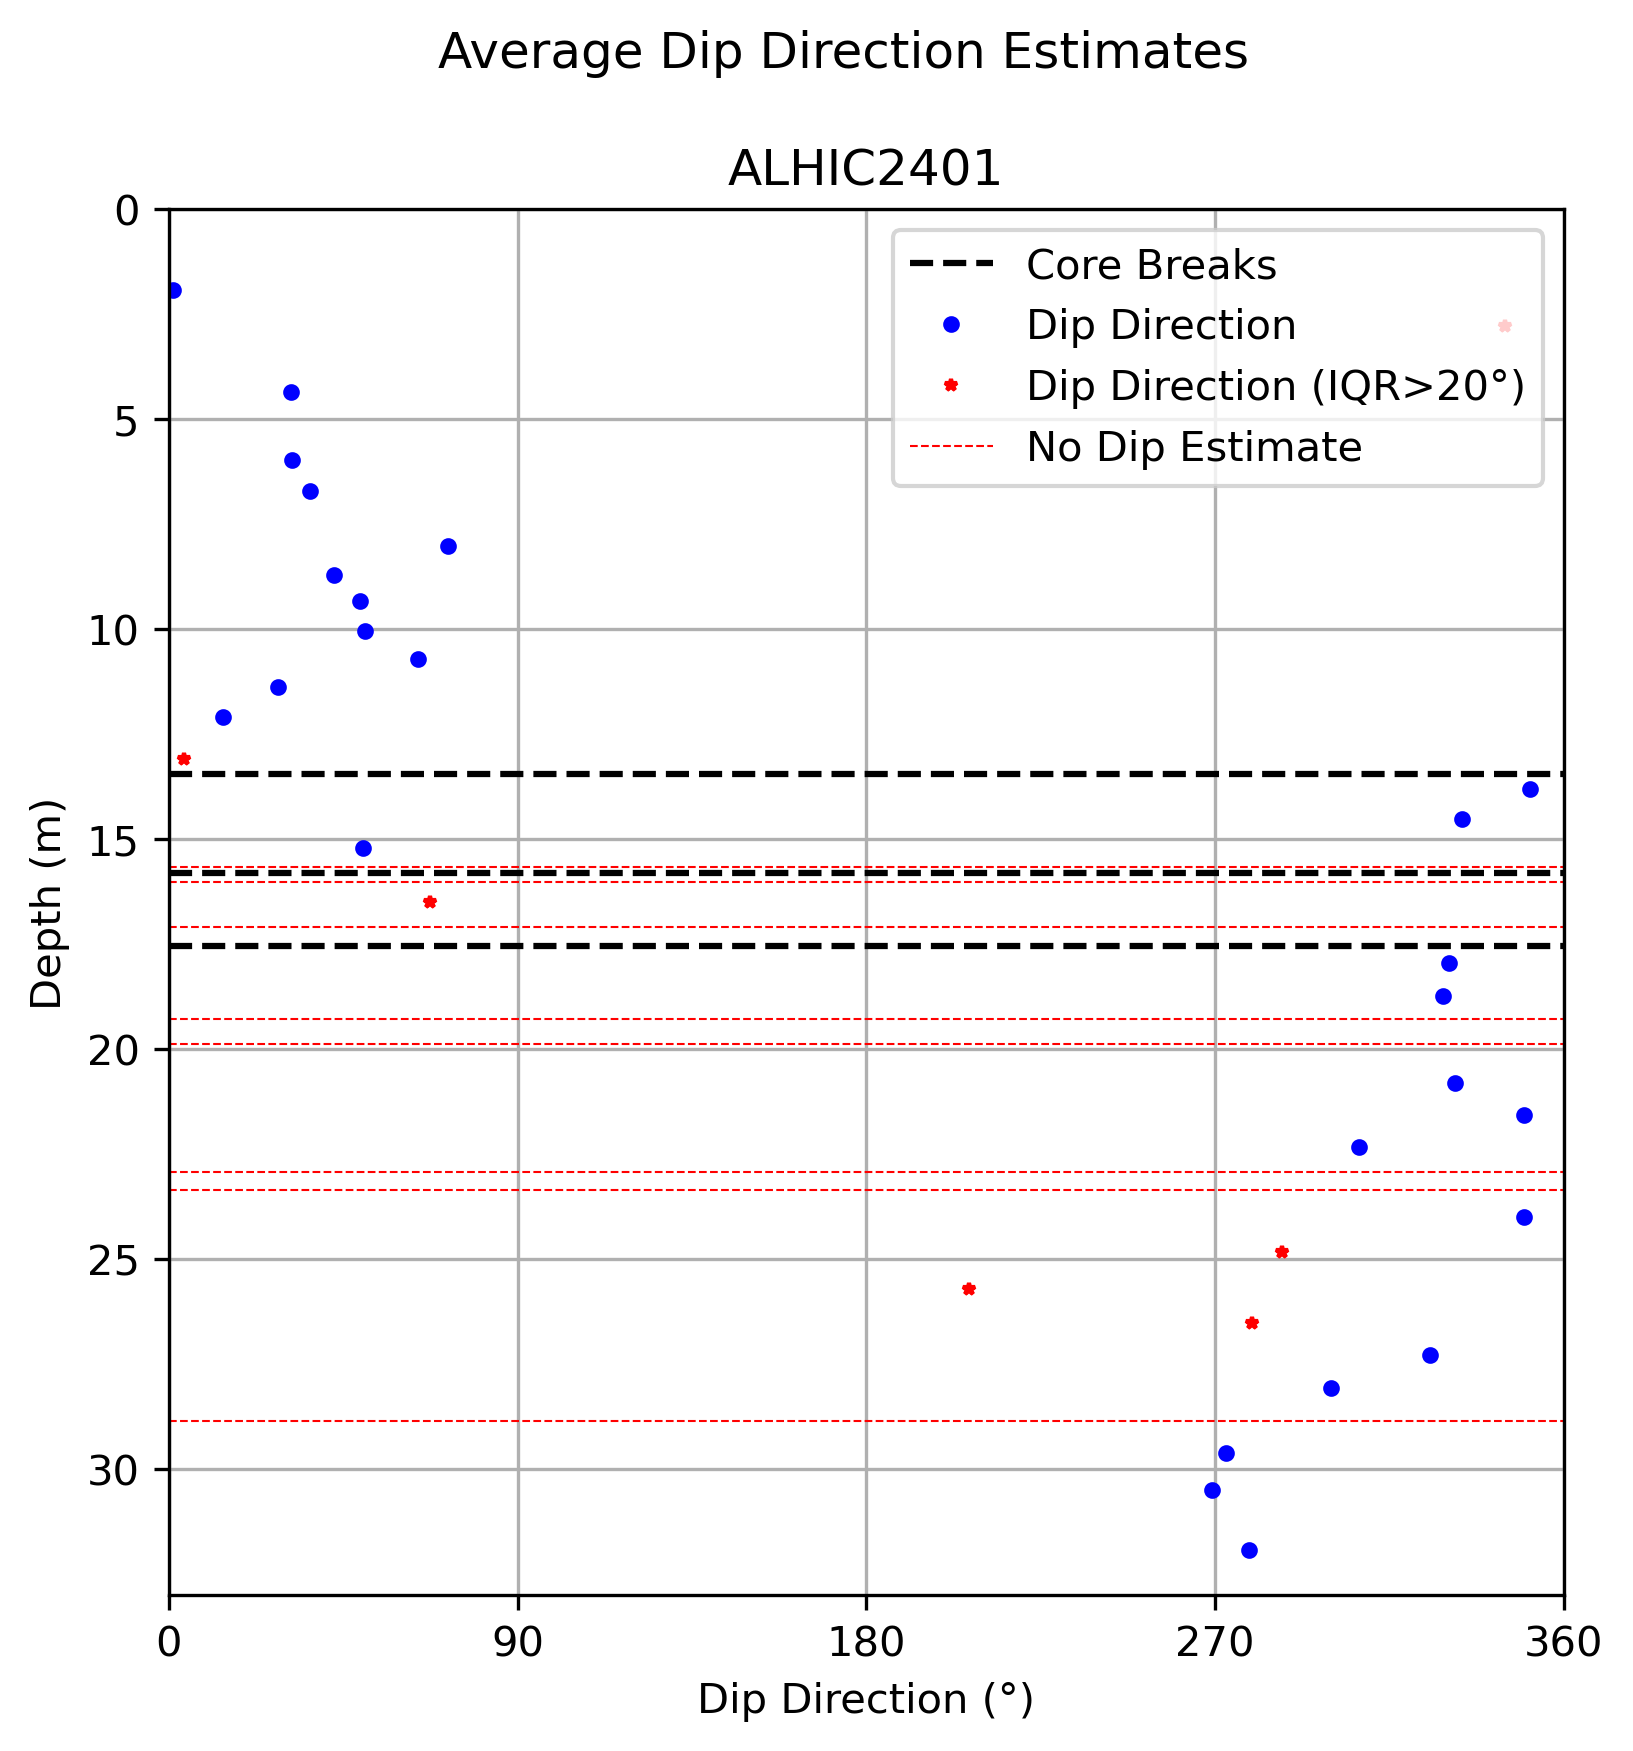

In [581]:
# make figure
fig, ax = plt.subplots(1,1,figsize=(6,6),dpi=300)

ax.set_ylabel('Depth (m)')
ax.set_xlabel('Dip Direction (°)')
ax.grid(True)
ax.set_xlim(0,360)
# set x axis grid to be in 90 degree increments
ax.set_xticks(np.arange(0,361,90))

# Set y-axis limits based on your data
# Adjust as needed based on the depth range of ALHIC2401
ax.set_ylim(33,0)  # Adjust this based on your data

def plot_dip_directions(df, ax, core_breaks, threshold,core):
    # plot dip directions
    for index, row in df.iterrows():
        # pull out values
        d = row['depth']
        dip = row['dip_percentiles'][2]
        q1 = row['dip_percentiles'][1]
        q3 = row['dip_percentiles'][3]
        dir = row['dip-direction-mean']

        # check for nan
        if np.isnan(dip):
            ax.plot([0, 360], [d, d], 'r--', linewidth=0.5)
        else:
            # check if exceeding value
            if abs(q3 - q1) < threshold:
                ax.plot(row['dip-direction-mean'], d, 'bo', markersize=3)
            else:
                ax.plot(row['dip-direction-mean'], d, 'r*', markersize=3)

    # plot core breaks
    labels = {}
    for b in core_breaks:
        label = 'Core Breaks'
        if label not in labels:
            ax.plot([0, 360], [b, b], 'k--', label=label)
            labels[label] = True
        else:
            ax.plot([0, 360], [b, b], 'k--')

    # add title 
    ax.set_title(core)

# Apply the function to dataframe
plot_dip_directions(alhic2401, ax, alhic2401_breaks, threshold, 'ALHIC2401')

# add legend
ax.plot([],[],'bo',markersize=3,label='Dip Direction')
ax.plot([],[],'r*',markersize=3,label='Dip Direction (IQR>20°)')
ax.plot([],[],'r--',linewidth=0.5,label='No Dip Estimate')
ax.legend(loc='upper right')
fig.suptitle('Average Dip Direction Estimates')

# save figure
plt.savefig(path_to_figures+'/dip_direction_2401.png')

## Save the dataframes

This let's us save the dataframes to a pickle file for later use, including the orientation data and dip we calculate here

In [582]:
# Save Output Dataframe with simple angle information
alhic2401['median-dip'] = alhic2401['dip_percentiles'].apply(lambda x: abs(x[2]))
alhic2401['IQR'] = alhic2401['dip_percentiles'].apply(lambda x: x[3]-x[1])

# save just the dip and dip direction as a csv
alhic2401[['section','depth','median-dip','dip-direction-mean','IQR']].to_csv(path_to_angles+'ALHIC2401_simple_dip.csv', index=False)

## Calculate ALHIC2401 Azimuth (Optional)

If you have orientation information for ALHIC2401, you can calculate the azimuth as shown below.

In [583]:
# This section would need to be updated with ALHIC2401's specific orientation information
# For now, it's commented out as an example

# # find average dip in ALHIC2401 above the first core break
# alhic2401_above_break = alhic2401[alhic2401['depth'] < alhic2401_breaks[0]]
# # filter for where the IQR is less than 20
# alhic2401_above_break = alhic2401_above_break[alhic2401_above_break['dip_percentiles'].apply(lambda x: x[3]-x[1]<20)]
# average_dip_direction = alhic2401_above_break['dip-direction-mean'].mean()
# std_dip_direction = alhic2401_above_break['dip-direction-mean'].std()
# print("Average Dip Direction above the first orientation lost is "+str(round(average_dip_direction,1)))
# print("Standard Deviation of Dip Direction above the first orientation lost is "+str(round(std_dip_direction,1)))

# # Move into degrees east framework
# o_line_azimuth = 59  # Replace with the correct value for ALHIC2401
# dip_azimuth = o_line_azimuth - average_dip_direction

# print("ALHIC2401 Dip azimuth is "+str(round((dip_azimuth+360)%360,1))+" degrees E of N")

## Make Plot showing trend with depth

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Excluding ALHIC2401 2
57.977571562937655
Excluding ALHIC2401 23
48.91316331795462
Excluding ALHIC2401 31
39.91283131081157
Excluding ALHIC2401 48
67.27311630669686
Excluding ALHIC2401 49
38.464734812855404
Excluding ALHIC2401 50
18.620471925000963


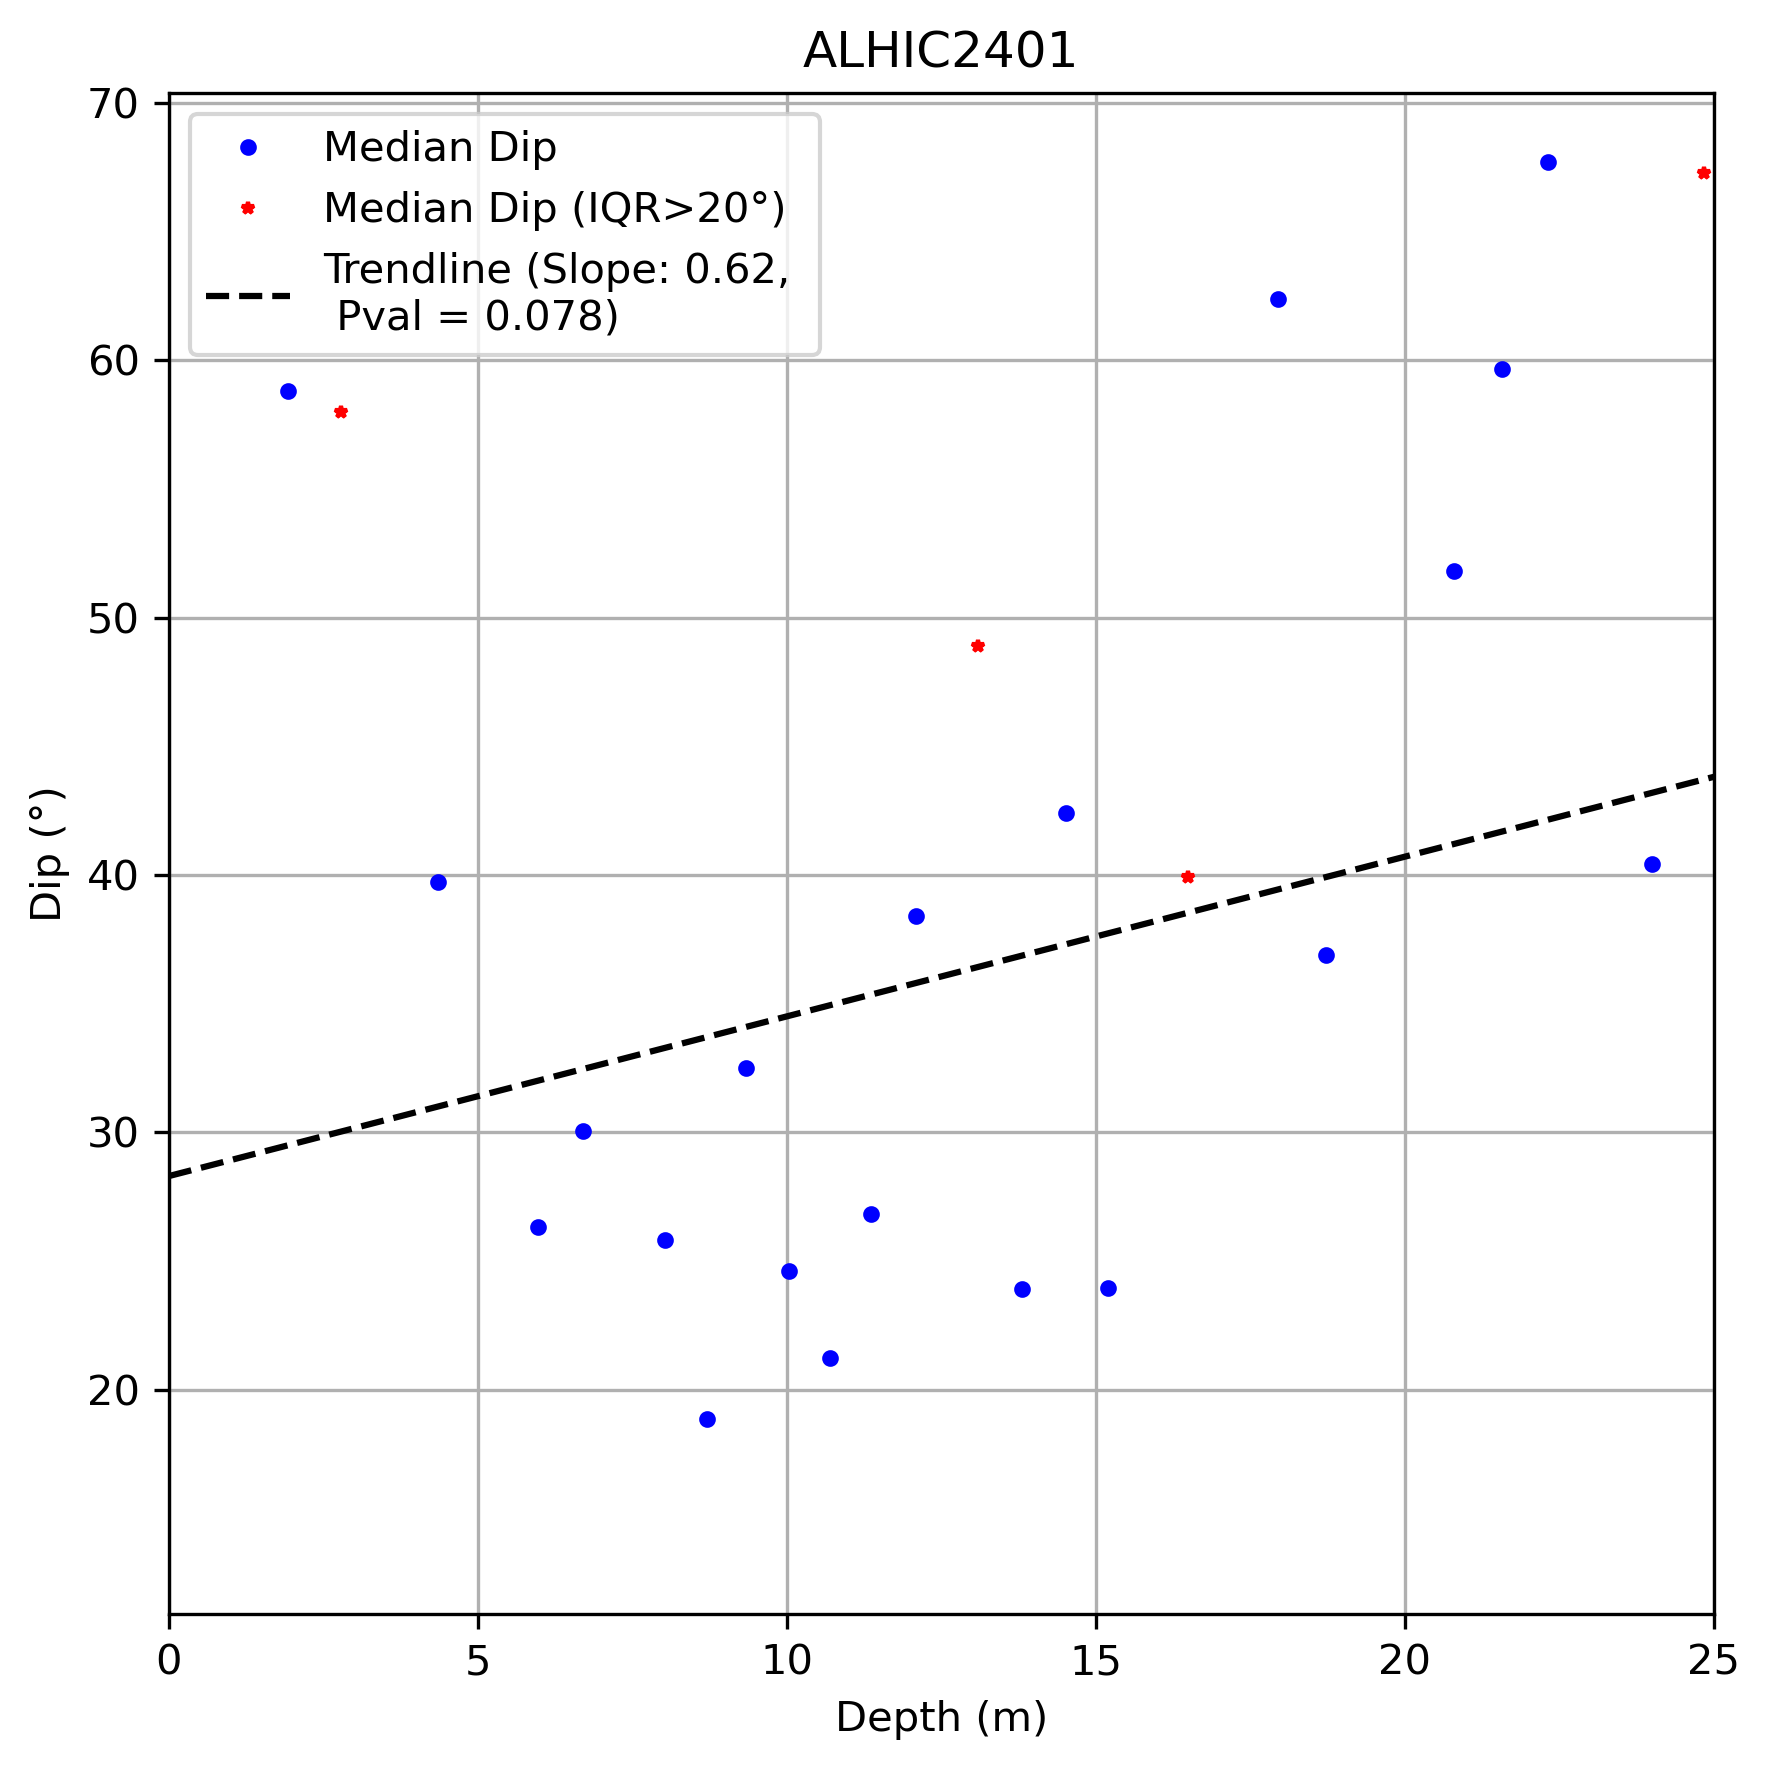

In [584]:
# set threshold to ignore
threshold = 20

def t_test_trend(df, threshold):
    # pull out median dip
    dip = np.array(df['dip_percentiles'].apply(lambda x:x[2]))
    q1 = np.array(df['dip_percentiles'].apply(lambda x:x[1]))
    q3 = np.array(df['dip_percentiles'].apply(lambda x:x[3]))

    # pull out depth and interquartile range
    depth = np.array(df['depth'])

    # remove nan from dip and depth vectors
    depth = depth[~np.isnan(dip)]
    q1 = q1[~np.isnan(dip)]
    q3 = q3[~np.isnan(dip)]
    dip = dip[~np.isnan(dip)]

    # pull out depth/dip values which exceed an interquartile range of threshold
    depth = depth[abs(q3-q1)<threshold]
    dip = dip[abs(q3-q1)<threshold]

    # perform t-test
    slope, intercept, r_value, p_value, std_err = stats.linregress(depth, abs(dip))

    return slope, intercept, p_value, depth, dip

# calculate t-test for alhic2401
slope2401, intercept2401, p_value2401, depth2401, dip2401 = t_test_trend(alhic2401, threshold)

# make figure
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=300)
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Dip (°)')
ax.set_xlim(0, 25)  # Adjust this based on your data
ax.grid(True)
ax.set_title('ALHIC2401')

# plot data
label1 = True
label2 = True
for index, row in alhic2401.iterrows():
    d = row['depth']
    dip = row['dip_percentiles'][2]
    
    # check for nan
    if not np.isnan(dip):
        q1 = row['dip_percentiles'][1]
        q3 = row['dip_percentiles'][3]

        if abs(q3-q1) < threshold:
            if label1:
                ax.plot(d, abs(dip), 'bo', markersize=3, label='Median Dip')
                label1 = False
            else:
                ax.plot(d, abs(dip), 'bo', markersize=3)
        else:
            print("Excluding ALHIC2401 " + row['section'])
            print(dip)
            if label2:
                ax.plot(d, abs(dip), 'r*', markersize=3, label='Median Dip (IQR>20°)')
                label2 = False
            else:
                ax.plot(d, abs(dip), 'r*', markersize=3)

# plot trendline
label = f'Trendline (Slope: {slope2401:.2f}, \n Pval = {p_value2401:.3f})'
ax.plot([0, max(alhic2401['depth'])+3], [intercept2401, intercept2401+slope2401*(max(alhic2401['depth'])+3)], 'k--', label=label)

handles, labels = ax.get_legend_handles_labels()
if 'Median Dip' in labels:
    order = [labels.index('Median Dip')] + [i for i in range(len(labels)) if i != labels.index('Median Dip')]
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
else:
    ax.legend()

plt.tight_layout()

# save figure
plt.savefig(path_to_figures+'trendline_2401.png', dpi=300)

# Circular vision

/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_90320/465907802.py:81: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(angles, radii, c=colors, cmap='coolwarm', s=50, marker=shapes[cnt], edgecolor='k', alpha=1, zorder=3)
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_90320/465907802.py:81: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(angles, radii, c=colors, cmap='coolwarm', s=50, marker=shapes[cnt], edgecolor='k', alpha=1, zorder=3)
/var/folders/b3/ghp5pyzj7_x9mhrs3x202bm80000gn/T/ipykernel_90320/465907802.py:81: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(angles, radii, c=colors, cmap='coolwarm', s=50, marker=shapes[cnt], edgecolor='k', alpha=1, zorder=3)


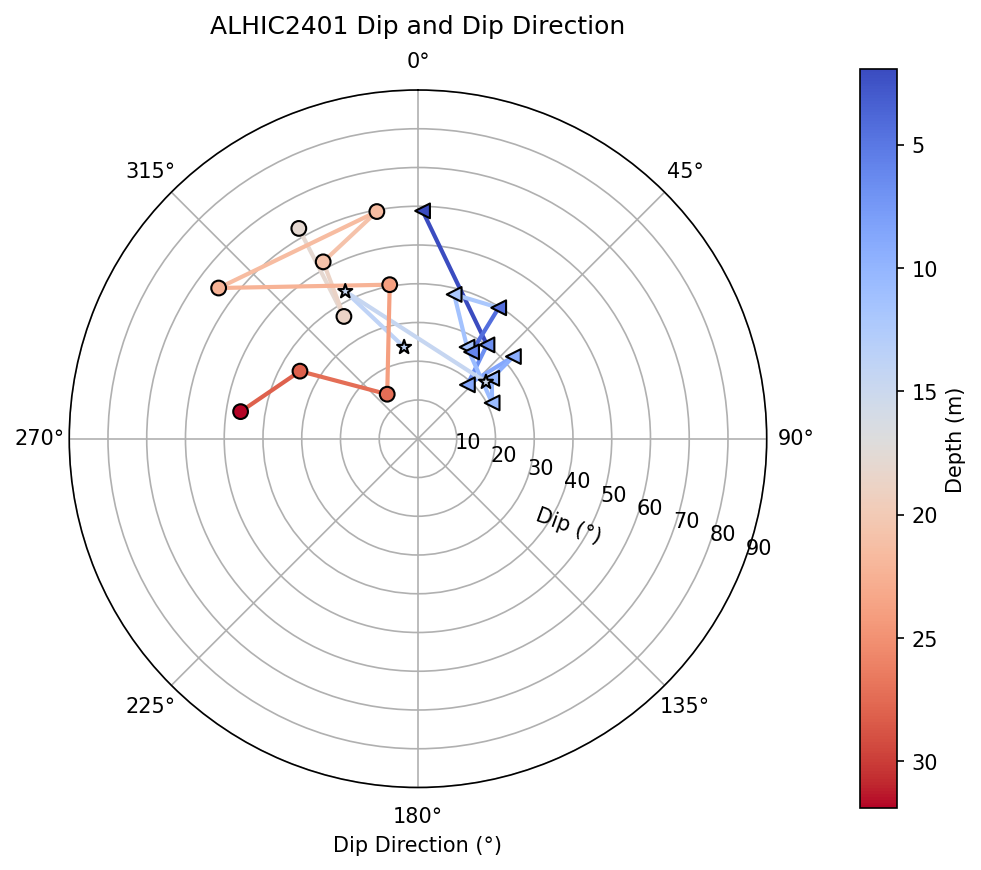

In [604]:
# Create a circular plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8), dpi=150)

# Filter rows with valid dip-direction-mean, median-dip, and IQR < 20
filtered_rows = valid_rows[valid_rows['IQR'] < 20]

# Convert dip-direction-mean to radians
angles = np.radians(filtered_rows['dip-direction-mean'])

# Use median-dip as the radius
radii = filtered_rows['median-dip']

# Normalize depth for color mapping
depths = filtered_rows['depth']
norm = plt.Normalize(depths.min(), depths.max())
colors = plt.cm.coolwarm(norm(depths))


# Plot the points
#sc = ax.scatter(angles, radii, c=colors, cmap='coolwarm', s=1, edgecolor='k', alpha=0.8)

# Add a colorbar to indicate depth
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])  # Set an empty array for the ScalarMappable
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label('Depth (m)')
cbar.ax.invert_yaxis()  # Flip the colorbar

# Set plot limits and labels
ax.set_rlim(0, 90)
ax.set_rlabel_position(110)
ax.set_theta_zero_location('N')  # Set 0 degrees to the top
ax.set_theta_direction(-1)       # Set clockwise direction
ax.set_title('ALHIC2401 Dip and Dip Direction', va='bottom')

ax.set_xlabel('Dip Direction (°)')

# Add a label at a specific position
label_position=ax.get_rlabel_position()
ax.text(np.radians(label_position+10),ax.get_rmax()/2.,'Dip (°)',
        rotation=-20,ha='center',va='center')

# Add lines between points (broken by alhic2401_breaks)

shapes = ['<', '*','s','o','^','v','p','h','D']
a = 0
break_secs = [24,30,37]
break_secs.append(1000)
cnt = 0
for b in break_secs:
    # Find rows in df where section is between a and b
    rows = filtered_rows[(filtered_rows['section'].astype(int) >= a) & (filtered_rows['section'].astype(int) < b)]
    
    # pull out values
    angles = np.radians(rows['dip-direction-mean'])
    radii = rows['median-dip']
    depths_set = rows['depth']
    colors = plt.cm.coolwarm(norm(depths_set))


    # Plot a line between the points
    if len(rows) > 1:
        angles = np.radians(rows['dip-direction-mean'])
        radii = rows['median-dip']
        depths = rows['depth']
        
        # Iterate through consecutive points to create gradient effect
        for i in range(len(rows) - 1):
            angle_start, angle_end = angles.iloc[i], angles.iloc[i + 1]
            radius_start, radius_end = radii.iloc[i], radii.iloc[i + 1]
            depth_start, depth_end = depths.iloc[i], depths.iloc[i + 1]
            
            # Interpolate color based on depth
            color_start = plt.cm.coolwarm(norm(depth_start))
            color_end = plt.cm.coolwarm(norm(depth_end))
            
            # Plot the segment with gradient color
            ax.plot([angle_start, angle_end], [radius_start, radius_end], 
                    color=color_start, linewidth=2)
            
    ax.scatter(angles, radii, c=colors, cmap='coolwarm', s=50, marker=shapes[cnt], edgecolor='k', alpha=1, zorder=3)
    a = b
    cnt+=1
